In [19]:
%matplotlib notebook
import os
import h5py
import tensorflow as tf
from tensorflow import keras
from models_STFT import UNet, CallBacks, DataGenerator
import matplotlib.pyplot as plt
from csbdeep.utils import plot_history
import obspy
import shutil
import numpy.ma as ma
import scipy.signal as signal
import numpy as np
from random import randint
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
import random

In [45]:
with open('my_list.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing = [str(item) for item in list_of_strings if item]

In [46]:
data=np.zeros((len(listing),640,2048))
for i in range(len(listing)):
    data[i]=np.load(listing[i])

In [69]:
def load_data(data):
    fs = 4000
    data_inputs=np.zeros((2,640,128,16,2))
    for j in range(data.shape[0]):
        _, _, Y_tf = signal.stft(data[j,0:1921], fs=fs, nperseg=255)
        data_inputs[0,j,:,:,0]=np.abs(Y_tf)
        data_inputs[0,j,:,:,1]=np.angle(Y_tf)
        _, _, Y_tf = signal.stft(data[j,2048-1921:2048], fs=fs, nperseg=255)
        data_inputs[1,j,:,:,0]=np.abs(Y_tf)
        data_inputs[1,j,:,:,1]=np.angle(Y_tf)
    return data_inputs

In [70]:
pretrainfile = os.path.join("model_time_frequency_noisy_inputs.h5")
model = keras.models.load_model(pretrainfile)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 16, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 16, 16)  304         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 128, 16, 16)  64         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                            

 batch_normalization_28 (BatchN  (None, 128, 16, 16)  64         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 gaussian_dropout_28 (GaussianD  (None, 128, 16, 16)  0          ['batch_normalization_28[0][0]'] 
 ropout)                                                                                          
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 16, 16)  2320        ['gaussian_dropout_28[0][0]']    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 128, 16, 16)  64         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
          

In [71]:
decalage = 2048-1921
file_paths = []
fs = 4000
save_dir = r"C:\Users\MFE\ansel\J-Invariant encoder\Time_frequency_reconstructions"
for i in range(data.shape[0]):
    data_to_input=load_data(data[i])
    [signal_mask_0,noise_mask_0]=model.predict(data_to_input[0])
    [signal_mask_1,noise_mask_1]=model.predict(data_to_input[1])
    array_to_save=np.zeros((640,2048))
    for j in range(data_to_input.shape[1]):
        _, autoencoder_signal_recon_0 = signal.istft(data_to_input[0,j,:,:,0]*signal_mask_0[j,:,:,0]*np.exp(1j*data_to_input[0,j,:,:,1]), fs=fs, nperseg=255)
        _, autoencoder_signal_recon_1 = signal.istft(data_to_input[1,j,:,:,0]*signal_mask_1[j,:,:,0]*np.exp(1j*data_to_input[1,j,:,:,1]), fs=fs, nperseg=255)
        full_recon=np.zeros(2048)
        for k in range(2048-1921):
            full_recon[k]=autoencoder_signal_recon_0[k]
        for k in range(2048-1921,1921):
            full_recon[k]=(autoencoder_signal_recon_0[k]+autoencoder_signal_recon_1[k-decalage])/2
        for k in range(1921,2048):
            full_recon[k]=autoencoder_signal_recon_1[k-decalage]
        array_to_save[j]=full_recon
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, f"array{i}.npy")
    np.save(file_path, array_to_save)
    file_paths.append(file_path)

20/20 [==============================] - 1s 46ms/step


20/20 [==============================] - 1s 47ms/step


20/20 [==============================] - 1s 47ms/step


20/20 [==============================] - 1s 50ms/step


In [72]:
with open('list_reconstructions.txt', 'w') as f:
    f.write('\n'.join(map(str, file_paths)))

In [73]:
with open('list_reconstructions.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
rec_listing = [str(item) for item in list_of_strings if item]

In [74]:
test = np.load(rec_listing[2])

In [75]:
test.shape

(640, 2048)

<IPython.core.display.Javascript object>


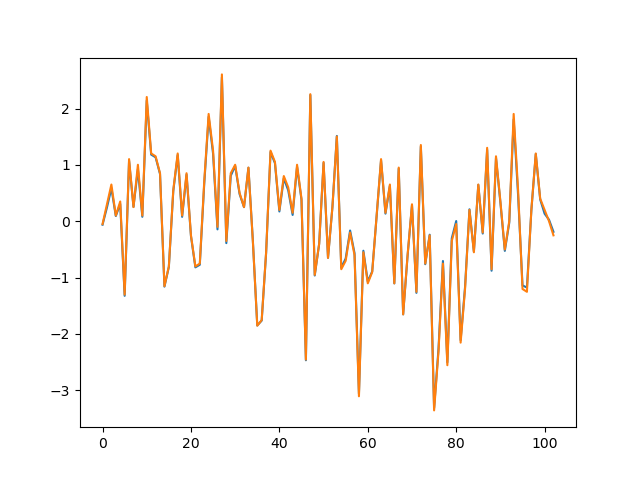

In [78]:
plt.figure()
plt.plot(test[200,0:2048:20])
plt.plot(data[2,200,0:2048:20])